In [1]:
import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import math
from typing import Dict, Tuple, List

In [10]:
df = {'A':[3 , 10],
       'B':[1 , 3],
       'C':[1 , 1],
       'D':[5 , 3],
       'E':[5 , 1],
       'F':[7 , 2]}

df = pd.DataFrame(df)

df = df.T

df.columns = ['x' , 'y']



# 計算距離矩陣
dist_mat = distance_matrix(df.values, df.values)

dist_df = pd.DataFrame(dist_mat , columns=df.index , index = df.index)
dist_df


dist_df_upper = dist_df.where(np.triu(np.ones(dist_df.shape), k=1).astype(bool))
print(dist_df_upper)

    A        B         C         D         E         F
A NaN  7.28011  9.219544  7.280110  9.219544  8.944272
B NaN      NaN  2.000000  4.000000  4.472136  6.082763
C NaN      NaN       NaN  4.472136  4.000000  6.082763
D NaN      NaN       NaN       NaN  2.000000  2.236068
E NaN      NaN       NaN       NaN       NaN  2.236068
F NaN      NaN       NaN       NaN       NaN       NaN


In [26]:
def find_cluster(df):
    find_friend = {} #dict
    for idx , row in df.iterrows():

        row_no_self = row[row > 0]
        # print(row_no_self)
        friend = row_no_self.idxmin()
        distance = row_no_self.min()
        find_friend[idx] = (friend , distance)
    # print(find_friend)
    return find_friend

new_df = find_cluster(dist_df)
print(new_df)

{'A': ('B', 7.280109889280518), 'B': ('C', 2.0), 'C': ('B', 2.0), 'D': ('E', 2.0), 'E': ('D', 2.0), 'F': ('D', 2.23606797749979)}


In [12]:
def find_cluster(df: pd.DataFrame) -> Dict[str, Tuple[str, float]]:
    find_friend = {}
    for idx, row in df.iterrows():
        # 只排除自己；不要用 row > 0，避免把「非自身但距離=0」也排掉
        row_no_self = row.drop(labels=[idx])
        friend = row_no_self.idxmin()
        distance = float(row_no_self.min())
        find_friend[idx] = (friend, distance)
    return find_friend
    


def find_min_value_in_cluster(find_friend: dict) -> float:

    min_val = float('inf')
    for _, (_, d) in find_friend.items():
        if d < min_val:
            min_val = d
    return min_val

    
     
def groups_from_nearest(
    friend: Dict[str, Tuple[str, float]],
    min_val: float,
    tol: float = 1e-9
) -> List[Tuple[str, ...]]:
    """
    取出本輪要合併的群：
      - 互為最近鄰且距離≈min_val 的配對 → 以 2-tuple 表示
      - 其餘點 → 以 1-tuple 表示
      - 依 friend.keys() 的原順序排序
    """
    # 1) 先過濾距離≈min_val 的邊
    filtered = {a: (b, d) for a, (b, d) in friend.items()
                if math.isclose(d, min_val, abs_tol=tol)}

    # 2) 只保留「互為最近鄰」的無向邊，並去重
    edges = set()
    for a, (b, _) in filtered.items():
        bb = filtered.get(b)
        if bb and bb[0] == a:
            edges.add(tuple(sorted((a, b))))  # ('B','C') 與 ('C','B') 合併成一個

    # 3) 為了輸出穩定，依原鍵順序排序
    order = {name: i for i, name in enumerate(friend.keys())}
    pairs = sorted(edges, key=lambda t: (order[t[0]], order[t[1]]))

    # 4) 把單點補進來（統一用 1-tuple 保持型別一致）
    paired_nodes = {x for u, v in pairs for x in (u, v)}
    singles = [(n,) for n in friend.keys() if n not in paired_nodes]

    return pairs + singles
def Centroid_Linkage(df , group)->pd.DataFrame:
    
    cluster_df = {}

    for g in group:
        # 1) 統一成員列表
        if isinstance(g, (tuple, list, set)):
            members = list(g)
        else:  # 單一字串，例如 'A'
            members = [g]
        
        # 2) 質心（x, y）：對群組成員的座標取平均
        sub = df.loc[members, ['x', 'y']]
        x = float(sub['x'].mean())
        y = float(sub['y'].mean())
        
        # 3) 群組名稱：單點用自身；多點用 "A+B+..."（若不想排序，就拿 members 原順序）
        label = members[0] if len(members) == 1 else "+".join(sorted(members))
        
        cluster_df[label] = (x, y)

    # 如需 DataFrame 方便後續計算：
    centroid_df = pd.DataFrame.from_dict(cluster_df, orient='index', columns=['x','y'])
    # centroid_df.index 就是群組標籤（如 'B+C', 'D+E', 'A', 'F'）

    return centroid_df




def Hierarchical_Clustering(DF):
    dist_mat = distance_matrix(DF.values, DF.values) # 這裡採用歐式距離
    dist_df = pd.DataFrame(dist_mat , columns=DF.index , index = DF.index)

    friend = find_cluster(dist_df)
    # print(friend)
    min_val = find_min_value_in_cluster(friend)
    pairs = groups_from_nearest(friend , min_val)
    print(pairs )
    centroid_df = Centroid_Linkage(DF , pairs)
    print(centroid_df)


    return centroid_df

def main(df: pd.DataFrame, tol: float = 1e-9, max_iters: int = 100):
    """
    反覆執行：
      1) 用距離矩陣找每點最近鄰
      2) 取全域最小距離
      3) 依「距離≈最小值 且互為最近鄰」形成本輪群組（pair + 單點）
      4) 以群組質心取代原點，進入下一輪
    終止條件：本輪沒有任何合併（全為單點）或只剩一群。
    
    回傳：
      final_df:   最後一輪的座標（可能只剩 1 群的質心）
      levels:     每一輪的群組（list[tuple]，單點是 1-tuple）
      min_values: 每一輪的全域最小距離
    """
    DF = df.copy()
    levels: List[List[Tuple[str, ...]]] = []
    min_values: List[float] = []

    for _ in range(max_iters):
        # 只剩一個群時結束
        if len(DF) <= 1:
            if len(DF) == 1:
                # 補記當前唯一群（自己）
                levels.append([(DF.index[0],)])
            break

        # 1) 距離矩陣
        dist_mat = distance_matrix(DF.values, DF.values)
        dist_df = pd.DataFrame(dist_mat, columns=DF.index, index=DF.index)

        # 2) 每點最近鄰 & 全域最小距離
        friend = find_cluster(dist_df)                 # dict: node -> (nbr, dist)
        min_val = find_min_value_in_cluster(friend)    # float

        # 3) 本輪群組（互為最近鄰且距離≈min 的 pair + 單點）
        groups = groups_from_nearest(friend, min_val, tol=tol)  # [('B','C'), ('D','E'), ('A',), ('F',)]
        levels.append(groups)
        min_values.append(min_val)

        # 沒有任何合併就停（全為 1-tuple）
        if all(len(g) == 1 for g in groups):
            break

        # 4) 用質心代表群，作為下一輪的資料
        DF = Centroid_Linkage(DF, groups)

    return DF, levels, min_values






df = {'A':[3 , 10],
       'B':[1 , 3],
       'C':[1 , 1],
       'D':[5 , 3],
       'E':[5 , 1],
       'F':[7 , 2]}

df = pd.DataFrame(df)

df = df.T

df.columns = ['x' , 'y']

final_df, levels, mins = main(df)

print("每輪最小距離：", mins)
for r, gs in enumerate(levels, 1):
    print(f"Round {r}: {gs}")
print("最終座標：\n", final_df)






每輪最小距離： [2.0, 2.0, 5.0, 8.0156097709407]
Round 1: [('B', 'C'), ('D', 'E'), ('A',), ('F',)]
Round 2: [('D+E', 'F'), ('B+C',), ('A',)]
Round 3: [('B+C', 'D+E+F'), ('A',)]
Round 4: [('A', 'B+C+D+E+F')]
Round 5: [('A+B+C+D+E+F',)]
最終座標：
                 x    y
A+B+C+D+E+F  3.25  6.0


In [39]:
from cluster import fit_custom_hclust, levels_to_linkage, plot_dendrogram, cut_tree_k
import pandas as pd

# 假資料（你的 6 點）
df = pd.DataFrame({
    'A':[3,10], 'B':[1,3], 'C':[1,1], 'D':[5,3], 'E':[5,1], 'F':[7,2]
}).T
df.columns = ['x','y']

final_df , levels , mins = fit_custom_hclust(df)


In [46]:
# final_df

# levels

# mins

# for i in levels:
#     print(i)

label = list(df.index)
label

['A', 'B', 'C', 'D', 'E', 'F']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


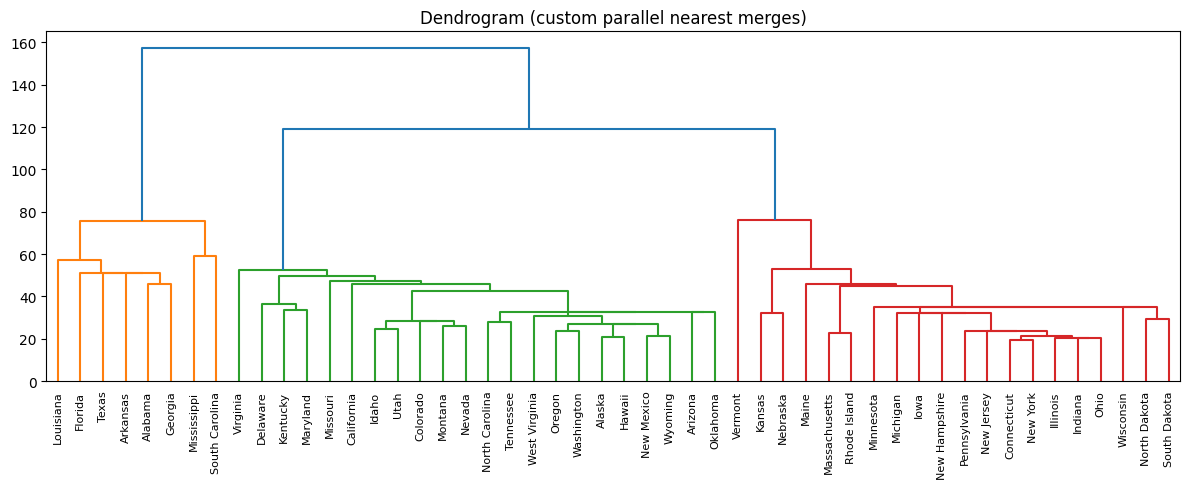

Alabama           1
Florida           1
Texas             1
Georgia           1
Arkansas          1
Louisiana         2
Mississippi       3
South Carolina    4
Virginia          5
Utah              5
Washington        5
Tennessee         5
West Virginia     5
Oregon            5
Oklahoma          5
North Carolina    5
New Mexico        5
Nevada            5
Montana           5
Missouri          5
Wyoming           5
Alaska            5
Arizona           5
California        5
Colorado          5
Kentucky          5
Delaware          5
Hawaii            5
Idaho             5
Maryland          5
Connecticut       6
South Dakota      6
Rhode Island      6
Pennsylvania      6
Illinois          6
Massachusetts     6
Indiana           6
New York          6
Iowa              6
New Jersey        6
New Hampshire     6
Kansas            6
Nebraska          6
Wisconsin         6
Maine             6
Minnesota         6
Michigan          6
North Dakota      6
Ohio              6
Vermont           7


In [20]:
%load_ext autoreload
%autoreload 2
import importlib, cluster

from cluster import fit_custom_hclust, levels_to_linkage, plot_dendrogram, cut_tree_k
import pandas as pd
import numpy as np
importlib.reload(cluster)

# 透過 rpy2 載入 R 資料
import os
os.environ.setdefault("R_HOME", "/Library/Frameworks/R.framework/Resources")

from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

r = ro.r
r('options(repos="https://cloud.r-project.org")')
r('if (!requireNamespace("cluster", quietly=TRUE)) install.packages("cluster")')
r('library(cluster); data("votes.repub", package="cluster")')

votes = pandas2ri.rpy2py(r['votes.repub'])
votes.columns = [int(str(c).lstrip('X')) for c in votes.columns]
votes = votes.apply(pd.to_numeric, errors='coerce').astype(float)
votes = votes.fillna(votes.mean(numeric_only=True))   # 用每年平均補 NA

final_df, levels, mins = fit_custom_hclust(votes)
labels = list(votes.index)
Z = levels_to_linkage(levels, mins, labels)

plot_dendrogram(Z, labels, figsize=(12, 5))
clusters7 = cut_tree_k(Z, labels, k=7)
clusters7.sort_values()


In [28]:
from cluster import fit_custom_hclust, levels_to_linkage
from map_plotly import plot_us_clusters_plotly

# votes 為你從 R 載入並處理好的 DataFrame（index=州名）
final_df, levels, mins = fit_custom_hclust(votes)
labels = list(votes.index)
Z = levels_to_linkage(levels, mins, labels)

plot_us_clusters_plotly(Z, labels, k=5, outfile="us_clusters.html")


✅ 已輸出互動地圖：us_clusters.html


,state,cluster,abbr
0,Alabama,1,AL
1,Alaska,3,AK
2,Arizona,3,AZ
3,Arkansas,1,AR
4,California,3,CA
5,Colorado,3,CO
6,Connecticut,4,CT
7,Delaware,3,DE
8,Florida,1,FL
9,Georgia,1,GA


In [2]:
import sys, platform, os
print("PY:", sys.executable)
print("VER:", sys.version)
print("ARCH:", platform.machine())
print("R_HOME:", os.environ.get("R_HOME"))


PY: /Users/papaya/.venvs/py312-arm/bin/python
VER: 3.12.11 (main, Jun  3 2025, 15:41:47) [Clang 16.0.0 (clang-1600.0.26.6)]
ARCH: arm64
R_HOME: /Library/Frameworks/R.framework/Resources


In [24]:
import importlib,cluster
from cluster import fit_custom_hclust, levels_to_linkage, plot_dendrogram, cut_tree_k
import numpy as np
importlib.reload(cluster)

import os

os.environ.setdefault("R_HOME" , "/Library/Frameworks/R.framework/Resources")
# 這一行是用來 讓像 rpy2 這類 Python↔R 套件知道 R 安裝位置（macOS CRAN 安裝的預設路徑）

from rpy2 import robjects as ro
#載入 rpy2 的核心介面 robjects，讓你能在 Python 內 呼叫 R、存取/建立 R 物件
from rpy2.robjects import pandas2ri
pandas2ri.activate() 

r = ro.r

# 3) 設 CRAN 鏡像，避免安裝時跳互動視窗
r('options(repos="https://cloud.r-project.org")')

r('if (!requireNamespace("cluster", quietly=TRUE)) install.packages("cluster")')

r('library(cluster)')

r('data("votes.repub", package = "cluster")')

df = ro.conversion.rpy2py(r('as.data.frame(votes.repub)'))



# # pandas → R
# import pandas as pd
# pdf2 = pd.DataFrame({"a":[1,2], "b":[3,4]})
# rdf2 = ro.conversion.py2rpy(pdf2)     # -> R data.frame

# ro.globalenv['rdf2'] = pdf2      # 放進 R 的 global env，名稱叫 rdf2
# r('str(rdf2)')                   # 在 R 端檢查
# r('print(head(rdf2))') 

* df = df.rename(columns={'交易標的種類': '標的'})

In [25]:
df.columns = [int(str(c).lstrip('X')) for c in df.columns]
df.columns


Index([1856, 1860, 1864, 1868, 1872, 1876, 1880, 1884, 1888, 1892, 1896, 1900,
       1904, 1908, 1912, 1916, 1920, 1924, 1928, 1932, 1936, 1940, 1944, 1948,
       1952, 1956, 1960, 1964, 1968, 1972, 1976],
      dtype='int64')

In [32]:
print(df.index)

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object')


In [37]:
for i in df.loc['Alabama']:
    print(type(i))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
